<a href="https://colab.research.google.com/github/beifa/kaggle_ashrae/blob/master/find_fetures_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gc
import os
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns 
from lightgbm import LGBMRegressor
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.metrics import mean_squared_log_error
from IPython.display import HTML
import matplotlib.pyplot as plt

import lightgbm as lgb

pd.set_option("max_columns", 500)
path = '/content/drive/My Drive/ASHRAE/data/'

#Data load

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train = pd.read_pickle(path + 'data_train_add_features.pkl.gz')
train.cloud_coverage = train.cloud_coverage.astype(np.int8)

# Поменять в тесте .cloud_coverage.astype(np.int8) !!!

In [0]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,mark_not_fill_air_temperature,mark_not_fill_cloud_coverage,mark_not_fill_dew_temperature,mark_not_fill_precip_depth_1_hr,mark_not_fill_sea_level_pressure,mark_not_fill_wind_direction,mark_not_fill_wind_speed,hour,month,weekday,dayofyear,weekofyear,quarter,monthday,holiday,rolling_back_air_temperature,rolling_forw_air_temperature,rolling_back_h_air_temperature,rolling_back_h_f_air_temperature,rolling_back_dew_temperature,rolling_forw_dew_temperature,rolling_back_h_dew_temperature,rolling_back_h_f_dew_temperature,e,es,rh,rec_air,rec_dew,rec_rh
103,105,0,0,23.303600,1,0,50623,2003,5,3.8,0.0,2.4,0.0,1020.900024,240.0,3.1,1,0,1,0,1,1,1,0,0,4,0,52,0,0,1,14.4,21.700001,23.9,14.4,8.9,10.6,8.3,-6.1,8.017771,7.261226,90.564156,bad,Good,big_h
104,106,0,0,0.374600,1,0,5374,2004,4,3.8,0.0,2.4,0.0,1020.900024,240.0,3.1,1,0,1,0,1,1,1,0,0,4,0,52,0,0,1,14.4,21.700001,23.9,14.4,8.9,10.6,8.3,-6.1,8.017771,7.261226,90.564156,bad,Good,big_h
106,107,0,0,175.184006,1,0,97532,2005,10,3.8,0.0,2.4,0.0,1020.900024,240.0,3.1,1,0,1,0,1,1,1,0,0,4,0,52,0,0,1,14.4,21.700001,23.9,14.4,8.9,10.6,8.3,-6.1,8.017771,7.261226,90.564156,bad,Good,big_h
107,108,0,0,91.265297,1,0,81580,1913,5,3.8,0.0,2.4,0.0,1020.900024,240.0,3.1,1,0,1,0,1,1,1,0,0,4,0,52,0,0,1,14.4,21.700001,23.9,14.4,8.9,10.6,8.3,-6.1,8.017771,7.261226,90.564156,bad,Good,big_h
108,109,0,0,80.930000,1,0,56995,1953,6,3.8,0.0,2.4,0.0,1020.900024,240.0,3.1,1,0,1,0,1,1,1,0,0,4,0,52,0,0,1,14.4,21.700001,23.9,14.4,8.9,10.6,8.3,-6.1,8.017771,7.261226,90.564156,bad,Good,big_h


In [0]:
reg = lgb.LGBMRegressor(
      learning_rate=0.05,
      objective='mae',
      n_estimators=350,
      num_threads=os.cpu_count(),
      num_leaves=31,
      max_depth=8,
      subsample=0.8,
      min_child_samples=50,
      random_state=42)

In [0]:
X = train.drop('meter_reading', axis = 'columns')
y = train.meter_reading

In [0]:
train.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'mark_not_fill_air_temperature',
       'mark_not_fill_cloud_coverage', 'mark_not_fill_dew_temperature',
       'mark_not_fill_precip_depth_1_hr', 'mark_not_fill_sea_level_pressure',
       'mark_not_fill_wind_direction', 'mark_not_fill_wind_speed', 'hour',
       'month', 'weekday', 'dayofyear', 'weekofyear', 'quarter', 'monthday',
       'holiday', 'rolling_back_air_temperature',
       'rolling_forw_air_temperature', 'rolling_back_h_air_temperature',
       'rolling_back_h_f_air_temperature', 'rolling_back_dew_temperature',
       'rolling_forw_dew_temperature', 'rolling_back_h_dew_temperature',
       'rolling_back_h_f_dew_temperature', 'e', 'es', 'rh', 'rec_air',
       'rec_dew', 'rec_rh'],
    

In [0]:
cat =  ['site_id','meter', 'cloud_coverage','primary_use', 'rec_air', 
        'rec_dew', 'rec_rh', 'holiday','mark_not_fill_cloud_coverage', 'mark_not_fill_dew_temperature',
        'mark_not_fill_precip_depth_1_hr', 'mark_not_fill_sea_level_pressure', 'mark_not_fill_wind_direction', 'mark_not_fill_wind_speed'] #drop 'building_id','year_built'

In [0]:
drop = ['year_built', 'building_id', 'precip_depth_1_hr', 'es','rolling_forw_air_temperature','month','monthday','rh','sea_level_pressure', 'floor_count']

In [0]:
reg.fit(X.drop(drop, axis = 'columns'), y, categorical_feature=cat)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cloud_coverage', 'holiday', 'mark_not_fill_cloud_coverage', 'mark_not_fill_dew_temperature', 'mark_not_fill_precip_depth_1_hr', 'mark_not_fill_sea_level_pressure', 'mark_not_fill_wind_direction', 'mark_not_fill_wind_speed', 'meter', 'primary_use', 'rec_air', 'rec_dew', 'rec_rh', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=8,
              min_child_samples=50, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=350, n_jobs=-1, num_leaves=31, num_threads=40,
              objective='mae', random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=0.8, subsample_for_bin=200000,
              subsample_freq=0)

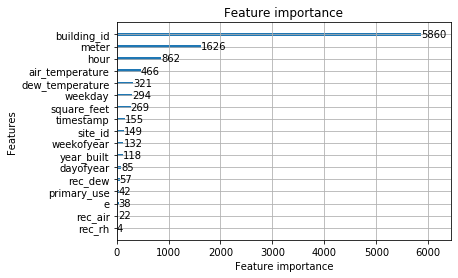

In [0]:
lgb.plot_importance(reg) #all

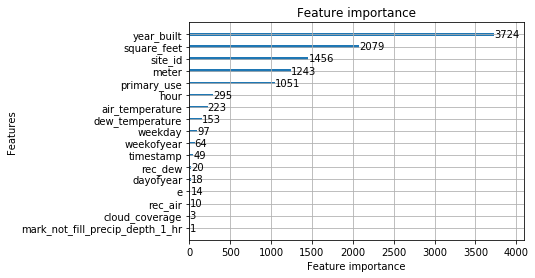

In [0]:
lgb.plot_importance(reg) #drop bild id

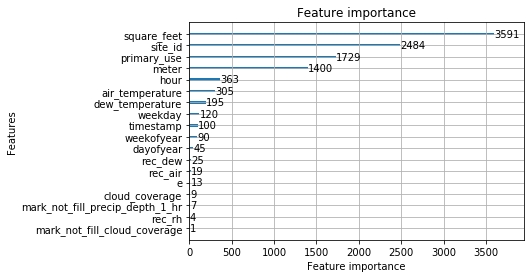

In [0]:
lgb.plot_importance(reg) #drop bildid, years

In [0]:
cat =  [ 'cloud_coverage', 'rec_air', 
        'rec_dew', 'rec_rh', 'holiday','mark_not_fill_cloud_coverage', 'mark_not_fill_dew_temperature',
        'mark_not_fill_precip_depth_1_hr', 'mark_not_fill_sea_level_pressure', 'mark_not_fill_wind_direction', 'mark_not_fill_wind_speed'] #drop 'building_id','year_built'
        #'meter','site_id','primary_use',

In [0]:
drop = ['square_feet','primary_use','site_id', 'meter','year_built', 'building_id', 'precip_depth_1_hr', 'es','rolling_forw_air_temperature','month','monthday','rh','sea_level_pressure', 'floor_count']

In [0]:
reg.fit(X.drop(drop, axis = 'columns'), y, categorical_feature=cat)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cloud_coverage', 'holiday', 'mark_not_fill_cloud_coverage', 'mark_not_fill_dew_temperature', 'mark_not_fill_precip_depth_1_hr', 'mark_not_fill_sea_level_pressure', 'mark_not_fill_wind_direction', 'mark_not_fill_wind_speed', 'rec_air', 'rec_dew', 'rec_rh']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=8,
              min_child_samples=50, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=350, n_jobs=-1, num_leaves=31, num_threads=40,
              objective='mae', random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=0.8, subsample_for_bin=200000,
              subsample_freq=0)

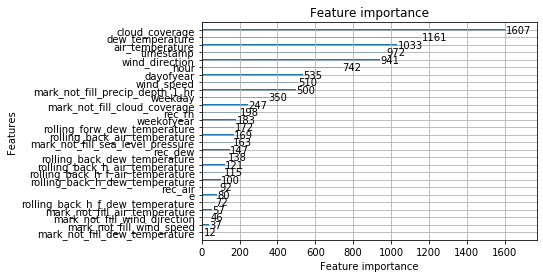

In [0]:
lgb.plot_importance(reg)

Тут можно четко сказать что у нас есть ключевые признаки
('building_id','year_built','meter','site_id','primary_use')
и так сказать остальные

Идеи:
  - Я хочу попробовать сделать это же предположение но уже только для каждого счетчика
  - Все признаки и также убираем ключевые
  - Дропнем на основе их самые неперспективные признаки



In [0]:
class BymeterFeatures(BaseEstimator, RegressorMixin):
  """
  model = lgbm with param
  col = metre columns
  
  Мы преследуем две вещи первое мы хотим посмотреть какие признаки больше или меньше влияют на счетчик(meter),
  а так же увидеть какие признаки оставить

  class.imp return array with fimpotance by each meter
  class.feature_importances_ return average

  predict add each meter
  """

  def __init__(self, model, col):
    self.model = model
    self.col = col #meter
    self.imp = [] #by each meters
    self.return_meters = []

  def fit(self, X, y):
    self.box = {}
    #imp = []
    for meter in X[self.col].unique(): #0,1,2,3
      temp = X[X[self.col] == meter].drop(self.col, axis = 'columns')      
      self.box[meter] = self.model.fit(temp, y.reindex_like(temp))
      #self.imp.append(self.box[meter].feature_importances_)
      del temp
    #avr = np.average(self.imp, axis=0) #средневзвешенное    
    #self.feature_importances_ = avr # no add meter we need drop col when vis or other
    return self

  def predict(self, X):
    result = np.zeros(len(X))#zero mask
    self.return_meters = []
    for meter in X[self.col].unique():
      ix = np.nonzero((X[self.col] == meter).to_numpy())
      predictions = self.box[meter].predict(X.iloc[ix].drop(columns=[self.col]))      
      self.return_meters.append((predictions, ix))
      result[ix] = predictions#fill zeros predict values 
    
    return result


In [0]:
Xsample = X.sample(frac = 0.05, random_state=0)#3kk
ysample = y.reindex(Xsample.index)

In [0]:
bf = BymeterFeatures(reg, col = 'meter')
bf.fit(Xsample, ysample)

BymeterFeatures(col='meter',
                model=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                    colsample_bytree=1.0,
                                    importance_type='split', learning_rate=0.05,
                                    max_depth=8, min_child_samples=50,
                                    min_child_weight=0.001, min_split_gain=0.0,
                                    n_estimators=350, n_jobs=-1, num_leaves=31,
                                    num_threads=4, objective='mae',
                                    random_state=42, reg_alpha=0.0,
                                    reg_lambda=0.0, silent=True, subsample=0.8,
                                    subsample_for_bin=200000,
                                    subsample_freq=0))

In [0]:
pd.Series(bf.feature_importances_, index=Xsample.drop('meter', axis = 1).columns).sort_values(ascending=False)

building_id                         2701.00
square_feet                         2489.75
year_built                          1208.50
primary_use                          784.75
hour                                 503.50
air_temperature                      503.25
dew_temperature                      397.00
timestamp                            376.25
floor_count                          282.25
dayofyear                            152.50
weekofyear                           111.50
sea_level_pressure                   100.75
cloud_coverage                        94.75
rh                                    92.75
weekday                               82.50
wind_direction                        67.50
mark_not_fill_precip_depth_1_hr       62.50
wind_speed                            46.50
monthday                              36.75
precip_depth_1_hr                     35.25
rolling_back_dew_temperature          34.50
rolling_forw_air_temperature          33.50
site_id                         

In [0]:
#features imp by each meters
bymeter = pd.DataFrame(bf.imp, columns =Xsample.drop('meter', axis = 1).columns,index = ['electricity', 'chilledwater', 'steam', 'hotwater'])
bymeter

,building_id,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,mark_not_fill_air_temperature,mark_not_fill_cloud_coverage,mark_not_fill_dew_temperature,mark_not_fill_precip_depth_1_hr,mark_not_fill_sea_level_pressure,mark_not_fill_wind_direction,mark_not_fill_wind_speed,hour,month,weekday,dayofyear,weekofyear,quarter,monthday,holiday,rolling_back_air_temperature,rolling_forw_air_temperature,rolling_back_h_air_temperature,rolling_back_h_f_air_temperature,rolling_back_dew_temperature,rolling_forw_dew_temperature,rolling_back_h_dew_temperature,rolling_back_h_f_dew_temperature,e,es,rh,rec_air,rec_dew,rec_rh
0,2792,121,48,1170,2643,1879,568,116,35,93,14,0,0,0,1,0,3,84,124,0,0,476,3,132,76,56,0,2,0,0,2,0,0,0,0,0,0,5,1,14,18,22,2
1,3051,350,2,794,2729,806,256,668,104,565,24,85,88,40,0,17,0,47,0,0,0,343,1,51,130,116,0,14,0,11,3,8,2,11,3,3,2,52,12,68,13,29,2
2,2387,688,0,358,1925,984,112,713,113,377,78,229,138,122,0,21,0,80,0,0,1,498,10,73,252,178,0,117,0,93,124,83,66,123,82,86,91,44,14,195,27,5,4
3,2574,346,83,817,2662,1165,193,516,127,553,25,89,44,24,0,6,0,39,0,0,0,697,8,74,152,96,0,14,0,2,5,1,0,4,2,3,4,9,5,94,20,45,2


In [0]:
def plot_cost_features(model, X, y, drop = []):
  """
  X,y = data
  drop col when we droped
  model = BymeterFeatures   
  """
  if drop:
    Xsample = X.drop(drop, axis='columns').sample(frac = 0.20, random_state=0)
    ysample = y.reindex(Xsample.index)    
  else:
    Xsample = X.sample(frac = 0.20, random_state=0)
    ysample = y.reindex(Xsample.index)  

  
  model.fit(Xsample, ysample)
  df = pd.DataFrame(model.imp, columns =Xsample.drop('meter', axis = 1).columns , index = ['electricity', 'chilledwater', 'steam', 'hotwater'])
  df.T.plot.bar(figsize=(20, 5))

out


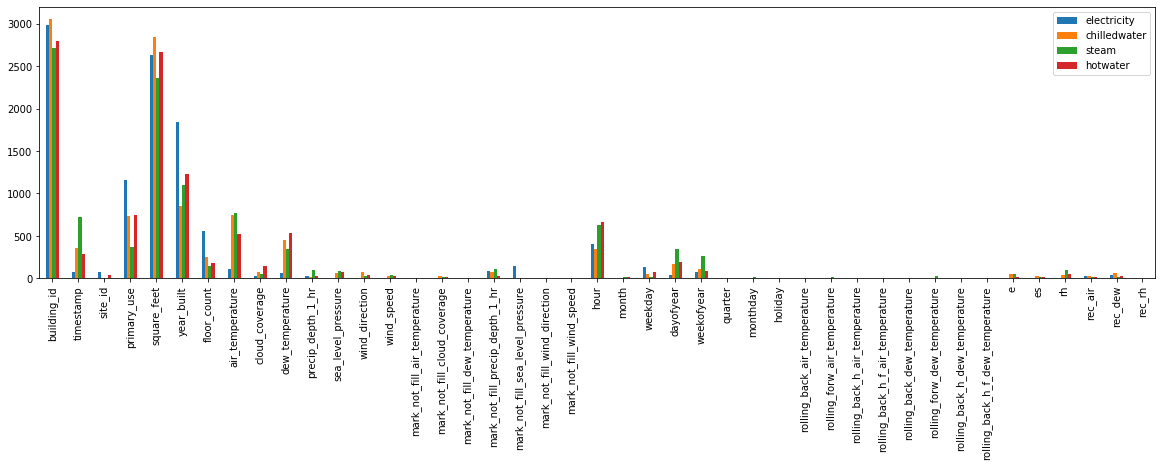

In [0]:
bf = BymeterFeatures(reg, col = 'meter')
plot_cost_features(bf, X, y, drop = [])

add ['building_id','year_built','site_id','primary_use', 'square_feet']

(3667749, 39) (3667749,) in


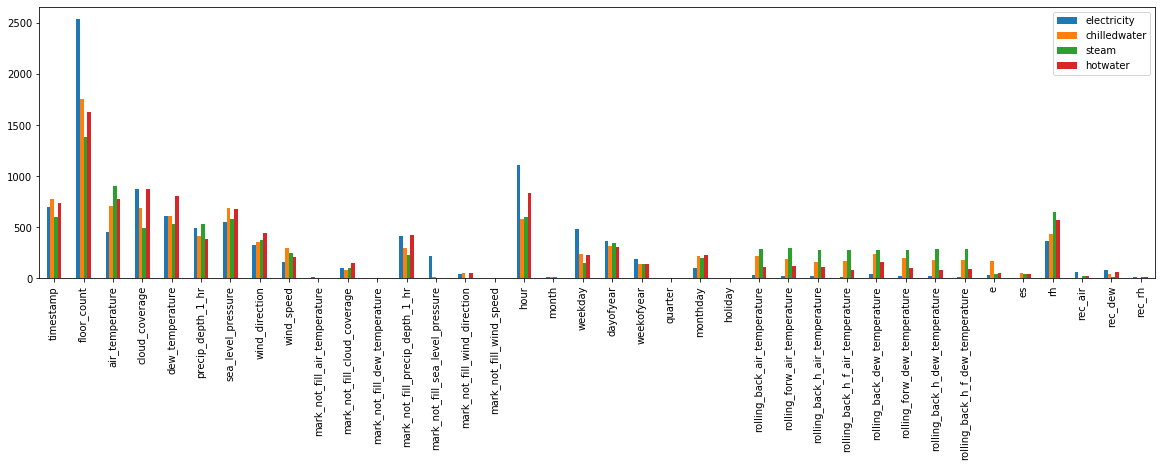

In [0]:
bf = BymeterFeatures(reg, col = 'meter')
plot_cost_features(bf, X, y, drop =['building_id','year_built','site_id','primary_use', 'square_feet'])

add floor_count

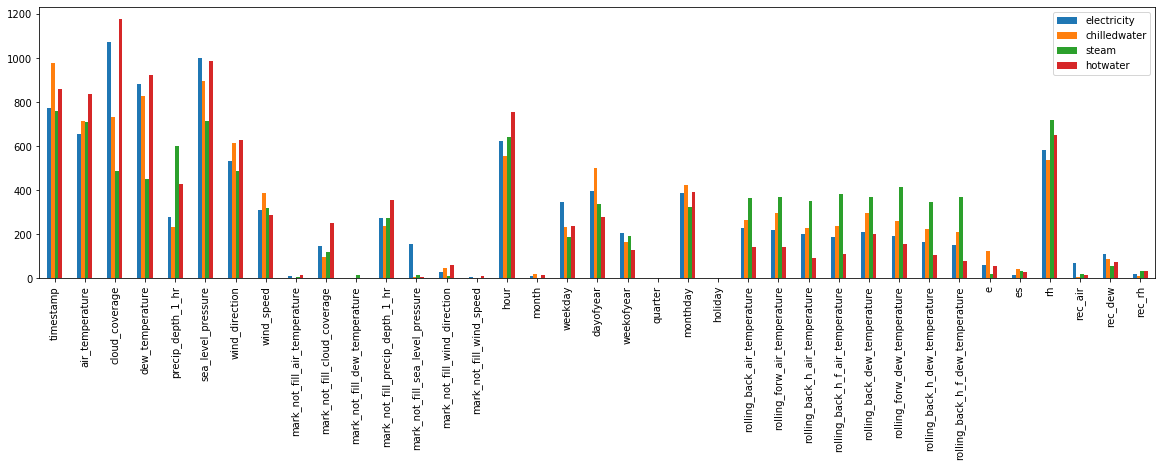

In [0]:
bf = BymeterFeatures(reg, col = 'meter')
plot_cost_features(bf, X, y, drop = ['building_id','year_built','site_id','primary_use', 'square_feet', 'floor_count'])

Мне не нравится что есть там и там(хм там там), я думаю что нужно исключить повторения по скольку мы вроде  этим и занимаемся
 дроп air, dew temperature and hour

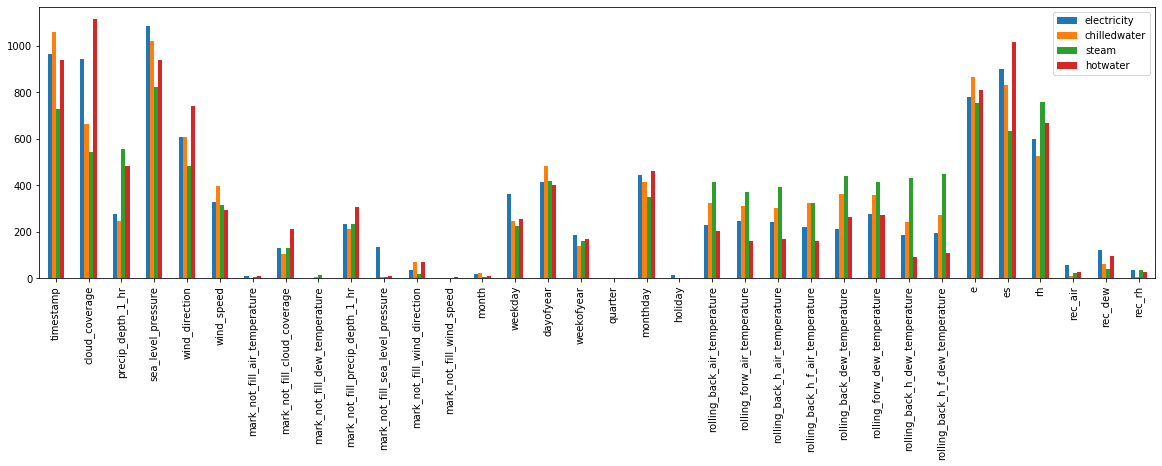

In [0]:
bf = BymeterFeatures(reg, col = 'meter')
plot_cost_features(bf, X, y, drop = ['building_id','year_built','site_id','primary_use', 'square_feet', 'floor_count', 'air_temperature', 'dew_temperature','hour'])

#error cv

In [0]:
train.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'mark_not_fill_air_temperature',
       'mark_not_fill_cloud_coverage', 'mark_not_fill_dew_temperature',
       'mark_not_fill_precip_depth_1_hr', 'mark_not_fill_sea_level_pressure',
       'mark_not_fill_wind_direction', 'mark_not_fill_wind_speed', 'hour',
       'month', 'weekday', 'dayofyear', 'weekofyear', 'quarter', 'monthday',
       'holiday', 'rolling_back_air_temperature',
       'rolling_forw_air_temperature', 'rolling_back_h_air_temperature',
       'rolling_back_h_f_air_temperature', 'rolling_back_dew_temperature',
       'rolling_forw_dew_temperature', 'rolling_back_h_dew_temperature',
       'rolling_back_h_f_dew_temperature', 'e', 'es', 'rh', 'rec_air',
       'rec_dew', 'rec_rh'],
    

In [0]:
primary_features = ['building_id','year_built','site_id','primary_use', 'square_feet', 'floor_count', 'timestamp', 'meter_reading', 'meter']
second_features = ['meter', 'timestamp', 'meter_reading','floor_count','air_temperature', 'cloud_coverage', 
                   'dew_temperature','sea_level_pressure','mark_not_fill_precip_depth_1_hr', 'hour', 'rh']
third_features = ['meter', 'timestamp', 'meter_reading', 'e', 'es', 'monthday', 'rolling_forw_air_temperature', 'rolling_back_h_air_temperature',
                  'rolling_back_h_f_air_temperature', 'rolling_back_dew_temperature', 'rolling_forw_dew_temperature', 'rolling_back_h_dew_temperature',
                  'rolling_back_h_f_dew_temperature',]

In [0]:
def rand_sample(idx, f = 0.25):
  #вернет выборку рандомную, f - коеф. размера выборки
  np.random.seed(0)
  sample_idx = np.random.choice(idx, int(len(idx) * f),replace=False)  
  return sample_idx

In [0]:
def idx_split(df, frac):
  idx = np.argsort(df.timestamp.values, kind='stable')
  split = np.array_split(idx, 12) #каждый месяц
  """
  у нас есть 12 сплитов и нам нужно чтобы трайн и тест не пересикались
  10 трайн, 2 тест

  """
  box = []
  for x in range(0, 12, 2):
    test_idx = np.concatenate(split[x:x + 2])#все четные
    train_idx = np.concatenate([split[ix % 12] for ix in range(x + 3, x + 11)])
    box.append((rand_sample(train_idx, frac), rand_sample(test_idx, frac)))
  return box

def method_name(data, target, verbose = True):
  #data array for each meter
  box = []
  #print(data, 'Data')
  for meter in data:
    #print(meter[1][0], 'metre loop')
    X = meter[0]
    y = target.iloc[meter[1][0]]
    err = np.sqrt(mean_squared_log_error(y, np.clip(X, 0, None)))    
    box.append(err)
  #print(box, 'Data ends')
  df =  pd.DataFrame(np.array(box)[np.newaxis, :], columns =['electricity', 'chilledwater', 'steam', 'hotwater'])
  if verbose:
    display(df)
  return np.array(box)

def find_std(arr):
  # in method name
  # take array, return sts by col, return df
  df = pd.DataFrame(arr, columns =['electricity', 'chilledwater', 'steam', 'hotwater']).std(axis = 0)
  display(df)
  return df

def cv(model, split, df, retn = False, std = True, timestamp = True, verbose = True):
  box = []
  box2 = [] # fck name is bad )) 

  if timestamp:
    X = df.drop('meter_reading', axis = 'columns')
  else:
    X = df.drop(['meter_reading', 'timestamp'], axis = 'columns')

  y = df.meter_reading
  for n, (train_idx, test_idx) in enumerate(split):
    train = X.iloc[train_idx]
    target = y.reindex_like(train)
    test = X.iloc[test_idx]
    target_test = y.reindex_like(test)
    print('Fit model')    
    model.fit(train, target)
    #print(train.shape, target.shape)
    #collect all predict by splits    
    box.append(pd.DataFrame(dict(target=target_test, prediction=model.predict(test)), index=target_test.index))         
    df_meters = method_name(model.return_meters, target_test, verbose)# return df
    box2.append(df_meters)       
  result = pd.concat(box).sort_index()
  #negatives values    
  #print(np.sqrt(mean_squared_log_error(result.target, abs(result.prediction))))
  if verbose:
    print(np.sqrt(mean_squared_log_error(result.target, np.clip(result.prediction, 0, None))))
    print('--------------------')      
  if std:
    if verbose:
      print('--------------------')
      print('Std')
      print('--------------------')
    return find_std(box2)    
  if retn:
    #return Series
    #return result.target, result.prediction
    return np.sqrt(mean_squared_log_error(result.target, np.clip(result.prediction, 0, None)))

In [0]:
a = [1.68569242180572, 1.7777467471685795, 0.9631612729099923, 2.601066504300817]
pd.DataFrame(np.array(a)[np.newaxis, :], columns =['electricity', 'chilledwater', 'steam', 'hotwater'])

,electricity,chilledwater,steam,hotwater
0,1.685692,1.777747,0.963161,2.601067


###cat hide

In [0]:
cat =  ['mark_not_fill_cloud_coverage', 'mark_not_fill_dew_temperature','mark_not_fill_air_temperature','holiday',
        'mark_not_fill_precip_depth_1_hr', 'mark_not_fill_sea_level_pressure', 'mark_not_fill_wind_direction', 'mark_not_fill_wind_speed',
        'building_id','meter', 'site_id','primary_use']

In [0]:
train_cat = train.copy()

In [0]:
train_cat['meter_reading'] = np.log1p(train_cat['meter_reading'])

In [0]:
for col in cat:
  train_cat[col] = train_cat[col].astype('category')

In [0]:
reg = lgb.LGBMRegressor()
split = idx_split(train_cat, 0.25)
bf = BymeterFeatures(reg, col = 'meter')
cv(bf, split, train_cat, retn = False)

Fit model
Predict by meters
------------------


,electricity,chilledwater,steam,hotwater
0,0.56691,0.365146,0.194366,0.489486


------------------
Split 0 ends
Fit model
Predict by meters
------------------


,electricity,chilledwater,steam,hotwater
0,0.439216,0.355969,0.457541,0.261127


------------------
Split 1 ends
Fit model
Predict by meters
------------------


,electricity,chilledwater,steam,hotwater
0,0.493485,0.487914,0.375117,0.268682


------------------
Split 2 ends
Fit model
Predict by meters
------------------


,electricity,chilledwater,steam,hotwater
0,0.378042,0.529606,0.486504,0.26208


------------------
Split 3 ends
Fit model
Predict by meters
------------------


,electricity,chilledwater,steam,hotwater
0,0.487741,0.377538,0.494323,0.230033


------------------
Split 4 ends
Fit model
Predict by meters
------------------


,electricity,chilledwater,steam,hotwater
0,0.587683,0.495131,0.169842,0.47784


------------------
Split 5 ends
0.422744027483803


###end

Текст это круто но но я хачу  у видеть разницу в цифрах по сплитам std, разницу видно но всетаки хочется циферку.

Ага а теперь я хачу все стд соединить

In [0]:
reg = lgb.LGBMRegressor(
      learning_rate=0.05,
      objective='mae',
      n_estimators=350,
      num_threads=os.cpu_count(),
      num_leaves=31,
      max_depth=8,
      subsample=0.8,
      min_child_samples=50,
      random_state=42)

In [0]:
reg = lgb.LGBMRegressor()
split = idx_split(train.loc[:,primary_features], 0.25)
bf = BymeterFeatures(reg, col = 'meter')
std_prim = cv(bf, split, train.loc[:, primary_features], retn = False, std = True, timestamp=True)

Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,1.780024,2.125948,1.192984,3.065242


------------------
Split 0 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,2.567813,1.963944,2.034232,1.344441


------------------
Split 1 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,2.444136,2.317879,2.077008,1.884898


------------------
Split 2 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,2.408571,2.82076,2.293179,1.7646


------------------
Split 3 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,2.572176,2.414017,2.93222,1.638641


------------------
Split 4 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,3.062584,2.770746,1.559084,2.426121


------------------
Split 5 ends
2.3659148758901543
--------------------
--------------------
Std
--------------------


electricity     0.412707
chilledwater    0.342535
steam           0.601076
hotwater        0.623339
dtype: float64

In [0]:
split = idx_split(train.loc[:, third_features], 0.25)
bf = BymeterFeatures(reg, col = 'meter')
std_third = cv(bf, split, train.loc[:, third_features], retn = False, std=True, timestamp=True) #2.007

Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,1.813844,3.224397,2.52723,3.428727


------------------
Split 0 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,2.304181,2.379719,1.797577,2.328951


------------------
Split 1 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,2.599632,2.132969,2.828656,3.710615


------------------
Split 2 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,2.028527,1.776352,1.880263,2.521033


------------------
Split 3 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,2.009402,2.622496,2.608724,3.226829


------------------
Split 4 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,4.651467,4.680227,5.691514,5.159828


------------------
Split 5 ends
3.0647602095538935
--------------------
--------------------
Std
--------------------


electricity     1.056716
chilledwater    1.040793
steam           1.433591
hotwater        1.014290
dtype: float64

In [0]:
split = idx_split(train.loc[:, second_features], 0.25)
bf = BymeterFeatures(reg, col = 'meter')
std_second = cv(bf, split, train.loc[:, second_features], retn = False, timestamp = True) #2.261819063147373

Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,2.045954,3.239693,2.141882,3.433662


------------------
Split 0 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,3.034054,2.512582,2.563148,2.135583


------------------
Split 1 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,3.085395,2.877291,2.554259,2.834402


------------------
Split 2 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,2.560386,3.218265,3.008913,2.392492


------------------
Split 3 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,2.905223,2.547715,3.09233,2.578535


------------------
Split 4 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,3.969973,4.170456,2.66791,3.666288


------------------
Split 5 ends
3.004071086853745
--------------------
--------------------
Std
--------------------


electricity     0.637999
chilledwater    0.613003
steam           0.345525
hotwater        0.600008
dtype: float64

In [0]:
split = idx_split(train, 0.25)
bf = BymeterFeatures(reg, col = 'meter')
std_all = cv(bf, split, train, retn = False, timestamp = True) #2.2038673333021497

Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,1.738011,2.366385,1.706364,3.149326


------------------
Split 0 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,2.823413,2.059671,2.022083,1.417517


------------------
Split 1 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,2.831199,2.343847,2.452352,1.717445


------------------
Split 2 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,2.535967,2.808917,2.285701,1.889036


------------------
Split 3 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,2.206409,2.159489,2.835861,1.64254


------------------
Split 4 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,3.19993,2.884128,1.566808,2.608987


------------------
Split 5 ends
2.4616280892065294
--------------------
--------------------
Std
--------------------


electricity     0.520310
chilledwater    0.338024
steam           0.476102
hotwater        0.666475
dtype: float64

In [0]:
#withot timestamp
stddf = pd.concat([std_prim, std_second, std_third, std_all], axis = 1)
stddf.columns = ['Primary', 'Second', 'Third', 'All']
stddf

,Primary,Second,Third,All
electricity,0.290356,0.593311,1.741750,0.383190
chilledwater,0.341031,0.716987,1.762404,0.269859
steam,0.782317,0.349777,1.014919,0.417800
hotwater,0.644882,0.685453,1.353035,0.680447


In [0]:
stddf_timestamp = pd.concat([std_prim, std_second, std_third, std_all], axis = 1)
stddf_timestamp.columns = ['Primary', 'Second', 'Third', 'All']
stddf_timestamp

,Primary,Second,Third,All
electricity,0.412707,0.637999,1.056716,0.520310
chilledwater,0.342535,0.613003,1.040793,0.338024
steam,0.601076,0.345525,1.433591,0.476102
hotwater,0.623339,0.600008,1.014290,0.666475


primary 2.36

second 3.06

third 3

all 2.46

Надо добавить категории

get_dum crash not use memory fck

In [0]:
cat = ['mark_not_fill_cloud_coverage', 'mark_not_fill_dew_temperature','mark_not_fill_air_temperature','holiday',
       'mark_not_fill_precip_depth_1_hr', 'mark_not_fill_sea_level_pressure', 'mark_not_fill_wind_direction', 
       'mark_not_fill_wind_speed']

In [0]:
cat2 = ['building_id',
        'site_id',
        'meter',        
        'primary_use',        
        'floor_count',
        'cloud_coverage',
        #'year_built' #need test very more val, more val  ha 117
        ]

In [0]:
train.rec_air = train.rec_air.cat.codes.astype("category")
train.rec_dew = train.rec_dew.cat.codes.astype("category")
train.rec_rh = train.rec_rh.cat.codes.astype("category")

In [0]:
cat3 = [
        'rec_air',
        'rec_dew',
        'rec_rh'
        ]

In [0]:
train.year_built.value_counts()

2009    2694313
2005    2455191
2006     807344
1976     566035
2004     488043
         ...   
1902      20416
1926      17566
1937      14924
1905       8783
2017       8782
Name: year_built, Length: 117, dtype: int64

In [0]:
train_cat = train.copy()

In [0]:
cat+cat2+cat3 #hhhahah

cat: +cat2+cat3: No such file or directory


In [0]:
for col in cat + cat2:
  train_cat[col] = train_cat[col].astype('category')

In [0]:
del train
gc.collect()

28

In [0]:
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18338747 entries, 103 to 20216099
Data columns (total 45 columns):
building_id                         category
meter                               category
timestamp                           int16
meter_reading                       float32
site_id                             category
primary_use                         category
square_feet                         int32
year_built                          int16
floor_count                         category
air_temperature                     float32
cloud_coverage                      category
dew_temperature                     float32
precip_depth_1_hr                   float32
sea_level_pressure                  float32
wind_direction                      float32
wind_speed                          float32
mark_not_fill_air_temperature       category
mark_not_fill_cloud_coverage        category
mark_not_fill_dew_temperature       category
mark_not_fill_precip_depth_1_hr     category

In [0]:
idx_cat = np.where(train_cat.drop(['meter_reading', 'meter', 'timestamp'], axis = 'columns').dtypes == 'category')[0]

In [0]:
X.iloc[:, idx_cat].columns.tolist()

In [0]:
X = train_cat.drop(['meter_reading'], axis = 'columns')
y = train_cat.meter_reading
reg = lgb.LGBMRegressor()
reg.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
pd.Series(reg.feature_importances_, index=X.columns).sort_values(ascending=False)

timestamp                           346
building_id                         315
meter                               207
sea_level_pressure                  204
monthday                            201
dew_temperature                     200
dayofyear                           166
rh                                  154
hour                                143
weekday                             120
air_temperature                     115
rolling_forw_dew_temperature         94
wind_direction                       87
rolling_back_dew_temperature         77
rolling_back_h_air_temperature       64
square_feet                          63
wind_speed                           61
cloud_coverage                       53
rolling_back_air_temperature         52
rolling_back_h_f_air_temperature     48
rolling_forw_air_temperature         44
rolling_back_h_f_dew_temperature     40
weekofyear                           29
rolling_back_h_dew_temperature       27
year_built                           23


In [0]:
split = idx_split(train_cat, 0.25)
bf = BymeterFeatures(reg, col = 'meter')
std_all = cv(bf, split, train_cat, retn = False, timestamp = True) #2.2038673333021497

Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,2.233937,1.697282,1.848284,2.080791


------------------
Split 0 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,2.153517,1.602215,2.402222,1.288858


------------------
Split 1 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,2.480383,2.513795,1.636306,1.400175


------------------
Split 2 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,1.634204,2.556061,2.385132,1.571167


------------------
Split 3 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,2.60403,1.742074,2.546527,1.326926


------------------
Split 4 ends
Fit model
------------------


,electricity,chilledwater,steam,hotwater
0,2.891473,2.555898,1.550962,2.15524


------------------
Split 5 ends
2.0315993245292576
--------------------
--------------------
Std
--------------------


electricity     0.432993
chilledwater    0.474213
steam           0.434277
hotwater        0.385562
dtype: float64

In [0]:
drop = ['es',
        'month', 
        'e',
        #'wind_speed',
        'monthday',
        'precip_depth_1_hr', 
        'weekofyear',
        #'wind_direction',
        #'rec_rh',
        #'mark_not_fill_dew_temperature',
        #'mark_not_fill_wind_speed',
        #'mark_not_fill_air_temperature',
        'quarter',
        'mark_not_fill_wind_direction',
        'mark_not_fill_cloud_coverage',
        'mark_not_fill_dew_temperature',
        'mark_not_fill_air_temperature',
        'mark_not_fill_precip_depth_1_hr',
        'mark_not_fill_sea_level_pressure', 
        'mark_not_fill_wind_direction', 
        'mark_not_fill_wind_speed',
        'rolling_back_air_temperature',
        #'rolling_forw_air_temperature',
        'rolling_back_h_air_temperature',
        'rolling_back_h_f_air_temperature',
        'rolling_back_dew_temperature',
        'rolling_forw_dew_temperature',
        'rolling_back_h_dew_temperature',
        'rolling_back_h_f_dew_temperature',
        'holiday',
        #'weekday',
        #'rec_air',
        #'rec_rh',
        'rec_dew'
        ]

"""
2.0020495952389212
Std
--------------------
electricity     0.410512
chilledwater    0.491564
steam           0.583856
hotwater        0.387296

++++++'rec_dew'

2.0029415027997133
--------------------
--------------------
Std
--------------------
electricity     0.409569
chilledwater    0.491074
steam           0.584691
hotwater        0.384886

"""
train_cat_drop = train_cat.drop(drop, axis = 'columns')

In [0]:
del train_cat
gc.collect()

84

In [0]:
droplist = train_cat_drop.columns

In [0]:
droplist.drop(['meter', 'timestamp', 'meter_reading'])

Index(['building_id', 'site_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'hour', 'weekday',
       'dayofyear', 'rolling_forw_air_temperature', 'rh', 'rec_air', 'rec_rh'],
      dtype='object')

In [0]:
reg = lgb.LGBMRegressor()
#split = idx_split(train_cat_drop, 0.25)
bf = BymeterFeatures(reg, col = 'meter')
#std_all = cv(bf, split, train_cat_drop, retn = False, timestamp = True) #2.2038673333021497

##---

In [0]:
def his_name_rnd_features(df, droplist, frac = .10):
  """
  я хачу рандомно брать признак(и количество признаков) из списка и дропать
  результат в дик
  dict[feture+ feature2] .... = cost

  df = data with cat
  droplist = list features you droped
"""

  temp_features =  []
  temp = {}
  for _ in range(len(droplist) *2):  
    droped = np.random.choice(droplist, int(len(droplist) * frac), replace=False)
    temp_features.append(droped)

  for f in np.asarray(temp_features):
    data = df.copy()
    print(data.shape)  
    data.drop(f, axis = 'columns', inplace=True)  
    print(data.shape, f)
    name = '---'.join(f)
    split = idx_split(data, 0.1)  
    cost = cv(bf, split, data, retn = True, timestamp = True, std=False, verbose=False)
    #func return cost after droped col
    del data
    gc.collect()
    temp[name] = cost
    print(f'Ends loop , cost {cost}')
  return temp

In [0]:
drop = ['es',
        'month', 
        'e',
        'wind_speed',
        'monthday',
        'precip_depth_1_hr', 
        'weekofyear',
        'wind_direction',
        'rec_rh',
        'mark_not_fill_dew_temperature',
        'mark_not_fill_wind_speed',
        'mark_not_fill_air_temperature',
        'quarter',
        'mark_not_fill_wind_direction',
        'mark_not_fill_cloud_coverage',
        'mark_not_fill_dew_temperature',
        'mark_not_fill_air_temperature',
        'mark_not_fill_precip_depth_1_hr',
        'mark_not_fill_sea_level_pressure', 
        'mark_not_fill_wind_direction', 
        'mark_not_fill_wind_speed',
        'rolling_back_air_temperature',
        'rolling_forw_air_temperature',
        'rolling_back_h_air_temperature',
        'rolling_back_h_f_air_temperature',
        'rolling_back_dew_temperature',
        'rolling_forw_dew_temperature',
        'rolling_back_h_dew_temperature',
        'rolling_back_h_f_dew_temperature',
        'holiday',
        'weekday',
        'rec_air',
        'rec_rh',
        'rec_dew'
        ]

In [0]:
%%time
#temp = his_name_rnd_features(train_cat_drop,
                             droplist.drop(['meter', 'timestamp', 'meter_reading']),
                             .50)

In [0]:
#pd.Series(temp).to_csv(path + 'droped_fetures_by_2.csv') # first try
#pd.Series(temp).to_csv(path + 'droped_fetures_by_2_1.csv')
#pd.Series(temp).to_csv(path + 'droped_fetures_by_3.csv')
#pd.Series(temp).to_csv(path + 'droped_fetures_by_4.csv')
#pd.Series(temp).to_csv(path + 'droped_fetures_by_5.csv')
#pd.Series(temp).to_csv(path + 'droped_fetures_by_6.csv')

1. оставить которые я выше отобрал и изних дропать
2. у величиваем количество (.20 -<4>-, .30 -<7> .40 -<9>- .50 -<12>- .70 -<16>-
3. объединим и опять пойдем


in Table_features.ipynb [Tables](https://colab.research.google.com/drive/1uQVuim4D6smFqnd2NddwQOk9pd6qCWI_#scrollTo=_kyzXHjVlFue)

